# IBM Data Science Specialization: The Battle of Neighborhoods

## Importing all required packages

In [269]:
import requests
import lxml.html as lh
import pandas as pd
from bs4 import BeautifulSoup
import geocoder # import geocoder
import numpy as np
from geopy.geocoders import Nominatim 
import folium
import os
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Exploring my Location

In [270]:
df_bang = pd.read_csv('Geospatial_Coordinates_Bangalore.csv')

In [271]:
df_bang[df_bang['Pincode']==560066]

,Pincode,Neighbourhood,Borough,Latitude,Longitude
36,560066,Whitefield,Bangalore South,12.969807,77.749963


In [272]:
my_lat = df_bang[df_bang['Pincode']==560066]['Latitude'].values[0]
my_long = df_bang[df_bang['Pincode']==560066]['Longitude'].values[0]
print('The geograpical coordinate of my location are {}, {}.'.format(my_lat, my_long))

The geograpical coordinate of my location are 12.969806599999998, 77.7499632.


In [273]:
CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20200411' # Foursquare API version
radius = 500
LIMIT = 50

In [274]:
my_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, my_lat, my_long, VERSION, radius, LIMIT)

In [275]:
result = requests.get(my_url).json()

In [276]:
items = result['response']['groups'][0]['items']
len(items)

9

In [277]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [278]:
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered

C:\Users\rajen\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Herbs and Spices,Eastern European Restaurant,"154, Main Road",Whitefield,12.968145,77.750862,"[{'label': 'display', 'lat': 12.96814544433936...",209,560066,IN,Bangalore,Karnātaka,India,"[154, Main Road (Whitefield), Bangalore 560066...",4bdf04390d69b713810e66d3
1,Golds Gym,Gym / Fitness Center,"# 48, Regent Prime, 1st Floor, Whitefield Main...",NaN,12.972217,77.750529,"[{'label': 'display', 'lat': 12.97221731296144...",275,560066,IN,Bangalore,Karnātaka,India,"[# 48, Regent Prime, 1st Floor, Whitefield Mai...",5281edb6498e7e50dc030016
2,Chef Baker's,Bakery,"SH 35, Whitefield",NaN,12.969730,77.751302,"[{'label': 'display', 'lat': 12.96972980757161...",145,NaN,IN,Bangalore,Karnātaka,India,"[SH 35, Whitefield, Bangalore, Karnātaka, India]",4dc3b4fc7d8b14fb45fe102a
3,Royal Orchid Suites,Hotel,"Vaswani Pinnacle Annexe, #11/3A,Whitefield Mai...",NaN,12.966774,77.751262,"[{'label': 'display', 'lat': 12.96677438955235...",365,560066,IN,Bangalore,Karnātaka,India,"[Vaswani Pinnacle Annexe, #11/3A,Whitefield Ma...",4bded843fe0e62b539fe0506
4,The river side bar and kitchen,Hotel Bar,"No 45 Whitefield Main Road, Opp Whitefield Pos...",Whitefield,12.967298,77.749614,"[{'label': 'display', 'lat': 12.96729799153577...",281,560066,IN,Bangalore,Karnātaka,India,"[No 45 Whitefield Main Road, Opp Whitefield Po...",5569dc3c498e444f82873db5
5,Punjabi Kitchen,Diner,NaN,NaN,12.968100,77.749804,"[{'label': 'display', 'lat': 12.96810042363152...",190,NaN,IN,NaN,NaN,India,[India],4ece766be5faa5ec00910101
6,Cheenavala,Kerala Restaurant,"No 104, Main Road,",NaN,12.966435,77.749368,"[{'label': 'display', 'lat': 12.96643510493249...",380,560066,IN,Whitefield,Karnātaka,India,"[No 104, Main Road,, Whitefield 560066, Karnāt...",549fb8c6498e5892fb9c3b8a
7,Glen's Bakehouse,Bakery,"442, State Highway 35",NaN,12.967490,77.749565,"[{'label': 'display', 'lat': 12.96749, 'lng': ...",261,560066,IN,Bangalore,Karnātaka,India,"[442, State Highway 35, Bangalore 560066, Karn...",58d7c9428ee560562c98c727
8,refresh,Café,NaN,NaN,12.965621,77.749234,"[{'label': 'display', 'lat': 12.96562148092858...",472,NaN,IN,NaN,NaN,India,[India],52db7e9d498e80be562b042c


In [13]:
venues_map = folium.Map(location=[my_lat, my_long], zoom_start=15) # generate map centred around Ecco


folium.features.CircleMarker(
    [my_lat, my_long],
    radius=10,
    popup='Ecco',
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

## Collecting required data for Toronto

In [14]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url).text

In [15]:
soup = BeautifulSoup(result, 'lxml')
col = []
values = []
table= soup.find('table', class_ = 'wikitable')

for match in table.find_all('th'):
    head = match.text.rstrip('\n')
    col.append((head,[]))

for item in table.find_all('td'):
    data = item.text.rstrip('\n')
    values.append(data)

for i in range(len(values)):
    col[i%3][1].append(values[i])
    i+=1

Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.tail()

,Postal code,Borough,Neighborhood
175,M5Z,Not assigned,
176,M6Z,Not assigned,
177,M7Z,Not assigned,
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...
179,M9Z,Not assigned,


### Refining the dataframe

In [16]:
df = df[df.Borough!='Not assigned'] # Deleting rows having Not assigned values in Borough column

In [17]:
df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [18]:
#df.reset_index(drop_index = True, Inplace = True) # Resetting the index

In [19]:
df['Neighborhood'] = df['Neighborhood'].str.replace('/',',') # Replacing # with ,

In [20]:
df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park , Harbourfront"
5,M6A,North York,"Lawrence Manor , Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [21]:
df['Neighborhood'] = df['Neighborhood'].str.replace(' , ',', ')

In [22]:
df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [23]:
df[df['Neighborhood']==''] #Checking if column Neighborhood has any blank values

,Postal code,Borough,Neighborhood


In [24]:
df.shape

(103, 3)

## Uploading geospatial data and merging with original dataframe

In [25]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv') #Creating geo_df with geospatial data
geo_df.rename(columns={"Postal Code":"Postal code"}, inplace = True) # Updating column names so that it will be easy for merge
geo_df.head()

,Postal code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [26]:
df = pd.merge(df, geo_df, on ='Postal code', how ='left') # Merging two datafrmaes 

In [27]:
df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [28]:
df.describe()

,Latitude,Longitude
count,103.000000,103.000000
mean,43.704608,-79.397153
std,0.052463,0.097146
min,43.602414,-79.615819
25%,43.660567,-79.464763
50%,43.696948,-79.388790
75%,43.745320,-79.340923
max,43.836125,-79.160497


### Checking unique values of boroughs and neighborhoods

In [29]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### Finding out coordinates of Toronto city

In [30]:
address = 'Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


### Creating  map of Toronto and neighborhood points

In [31]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [32]:
toronto_df = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_df.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [33]:
toronto_df.describe()

,Latitude,Longitude
count,39.000000,39.000000
mean,43.667135,-79.389873
std,0.023478,0.037451
min,43.628947,-79.484450
25%,43.649765,-79.405678
50%,43.662301,-79.387383
75%,43.677957,-79.376474
max,43.728020,-79.293031


In [34]:
toronto_df.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

In [35]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


## Finding venues nearby for all the neighborhoods

In [36]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url

In [37]:
results = requests.get(url).json()['response']['venues']
#a = []
#a.append([b['name'] for b in results])
#a
#results

In [38]:
venues_list = []
for items in results:
    try:
        v_name = items['name']
    except:
        v_name = ''
    try:
        v_lat = items['location']['lat']
    except:
        v_lat = ''
    try:
        v_lng = items['location']['lng'],
    except:
        v_lng = ''
    try:
        v_code = items['location']['postalCode'][:4]
    except:
        v_code = ''
    try:
        v_c_name = items['categories'][0]['name']
    except:
        v_c_name = ''
    venues_list.append([(v_name, v_lat, v_lng, v_code, v_c_name)])
                     
#venues_list

In [39]:
nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

In [40]:
nearby_venues.columns= ['Venue_Name', 'Venue_Latitude', 'Venue_Longitude','Postal_Code', 'Venue_Category']

In [41]:
nearby_venues.head()

,Venue_Name,Venue_Latitude,Venue_Longitude,Postal_Code,Venue_Category
0,City Hall Council Chambers,43.651827,"(-79.38394893163043,)",,City Hall
1,Toronto City Hall,43.653140,"(-79.38396692276001,)",M5H,City Hall
2,City of Toronto Civic Innovation Office,43.653454,"(-79.383952,)",M5H,City Hall
3,City Hall Podium Green Roof,43.653504,"(-79.38386645704847,)",,Garden
4,GoodLife Fitness Toronto Bell Trinity Centre,43.653436,"(-79.382314,)",M5G,Gym


In [42]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

50 venues were returned by Foursquare.


In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

In [45]:
toronto_venues.shape

(1190, 7)

In [46]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,50,50,50,50,50,50
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,18,18,18,18,18,18
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",18,18,18,18,18,18
Central Bay Street,50,50,50,50,50,50
Christie,18,18,18,18,18,18
Church and Wellesley,50,50,50,50,50,50
"Commerce Court, Victoria Hotel",50,50,50,50,50,50
Davisville,33,33,33,33,33,33


In [47]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 213 uniques categories.


In [48]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(100)

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
toronto_onehot.shape

(1190, 213)

In [50]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Business reply mail Processing CentrE,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,Central Bay Street,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0


In [51]:
toronto_grouped.shape

(39, 213)

In [52]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1        Cocktail Bar  0.06
2  Italian Restaurant  0.04
3            Beer Bar  0.04
4         Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.14
1     Coffee Shop  0.09
2  Breakfast Spot  0.09
3   Grocery Store  0.05
4    Intersection  0.05


----Business reply mail Processing CentrE----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2         Auto Workshop  0.06
3        Farmers Market  0.06
4  Fast Food Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3             Plane  0.06
4           Airport  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.20
1      Sandwich Place  0.06

In [53]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Seafood Restaurant,Restaurant,Italian Restaurant,Farmers Market,Café,Bakery
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Stadium,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Burrito Place,Restaurant
2,Business reply mail Processing CentrE,Light Rail Station,Yoga Studio,Auto Workshop,Fast Food Restaurant,Farmers Market,Comic Shop,Garden Center,Park,Pizza Place,Burrito Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Boutique,Sculpture Garden,Bar
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bubble Tea Shop,Burger Joint,Ice Cream Shop,Department Store,Salad Place,Ramen Restaurant


## Cluster Neighborhoods

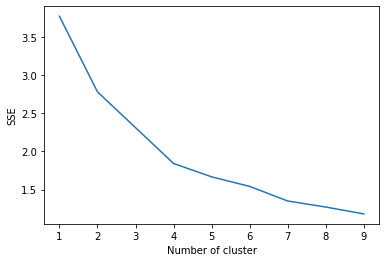

In [55]:
# set number of clusters
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
sse = {}
for kclusters in range(1, 10):  

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, max_iter=1000).fit(toronto_grouped_clustering)
    sse[kclusters] = kmeans.inertia_

    # check cluster labels generated for each row in the dataframe
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [56]:
k = 7
kmeans = KMeans(n_clusters=7, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:100] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0, 1, 0,
       0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0])

In [57]:
#neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace =True)
#neighborhoods_venues_sorted.head()

In [58]:
# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Park,Bakery,Theater,Restaurant,Café,Breakfast Spot,Farmers Market,Hotel
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Diner,Mexican Restaurant,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café,Park
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Café,Tea Room,Middle Eastern Restaurant,Ramen Restaurant,Bookstore,Theater,Restaurant,Clothing Store,Sandwich Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Gastropub,Coffee Shop,Creperie,Seafood Restaurant,Hotel,Farmers Market,Cosmetics Shop,Optical Shop,Ice Cream Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,6,Trail,Pub,Health Food Store,Wine Shop,Cupcake Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


In [93]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [231]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Park,Bakery,Theater,Restaurant,Café,Breakfast Spot,Farmers Market,Hotel
1,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Diner,Mexican Restaurant,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café,Park
2,Downtown Toronto,0,Coffee Shop,Café,Tea Room,Middle Eastern Restaurant,Ramen Restaurant,Bookstore,Theater,Restaurant,Clothing Store,Sandwich Place
3,Downtown Toronto,0,Café,Gastropub,Coffee Shop,Creperie,Seafood Restaurant,Hotel,Farmers Market,Cosmetics Shop,Optical Shop,Ice Cream Shop
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Seafood Restaurant,Restaurant,Italian Restaurant,Farmers Market,Café,Bakery
6,Downtown Toronto,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Bubble Tea Shop,Burger Joint,Ice Cream Shop,Department Store,Salad Place,Ramen Restaurant
7,Downtown Toronto,0,Grocery Store,Café,Park,Nightclub,Diner,Italian Restaurant,Restaurant,Baby Store,Candy Store,Athletics & Sports
8,Downtown Toronto,0,Coffee Shop,American Restaurant,Café,Restaurant,Concert Hall,Pizza Place,Seafood Restaurant,Steakhouse,Mediterranean Restaurant,Opera House
9,West Toronto,0,Pharmacy,Bakery,Wine Shop,Gym / Fitness Center,Park,Pizza Place,Middle Eastern Restaurant,Café,Brewery,Bar
10,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Brewery,Plaza,Café,Park,Chinese Restaurant,Monument / Landmark,Beer Bar


In [232]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Playground,Restaurant,Wine Shop,Cupcake Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant


In [233]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,Garden,Wine Shop,Cupcake Shop,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant


In [234]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,3,Sushi Restaurant,Park,Trail,Jewelry Store,Bus Line,Wine Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [235]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Downtown Toronto,4,Park,Trail,Playground,Cuban Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dim Sum Restaurant,Dessert Shop


In [236]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,5,Park,Bus Line,Dim Sum Restaurant,Swim School,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop


In [237]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,6,Trail,Pub,Health Food Store,Wine Shop,Cupcake Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store,Diner


## Loading Apartment data to dataframe

In [210]:
app_df = pd.read_csv('Toronto_apartment_rentals.csv')
app_df.shape


(1123, 7)

In [211]:
app_df[app_df.columns[6]] = app_df[app_df.columns[6]].replace('[\$,]', '', regex=True).astype(float)

In [212]:
app_df.head()

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
0,2,2.0,0,"3985 Grand Park Drive, 3985 Grand Park Dr, Mis...",43.581639,-79.648193,2450.0
1,1,1.0,1,"361 Front St W, Toronto, ON M5V 3R5, Canada",43.643051,-79.391643,2150.0
2,1,1.0,0,"89 McGill Street, Toronto, ON, M5B 0B1",43.660605,-79.378635,1950.0
3,2,2.0,0,"10 York Street, Toronto, ON, M5J 0E1",43.641087,-79.381405,2900.0
4,1,1.0,0,"80 St Patrick St, Toronto, ON M5T 2X6, Canada",43.652487,-79.389622,1800.0


In [217]:
app_df.drop(app_df[app_df['Price']<1500]. index, axis=0, inplace=True)
app_df.drop(app_df[app_df['Price']>2200]. index, axis=0, inplace=True)
app_df.drop(app_df[app_df['Bedroom']<2]. index, axis=0, inplace=True)
app_df.drop(app_df[app_df['Bathroom']<2]. index, axis=0, inplace=True)

In [225]:
app_df

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
112,2,2.0,0,"m1s0l7, Canada",43.780033,-79.281055,2184.0
225,2,2.0,0,"m1s0l7, Canada",43.780033,-79.281055,2184.0
285,2,2.0,0,"540 Sherbourne St, Toronto, ON M4X 1L2, Canada",43.669146,-79.375902,2000.0
308,2,2.0,0,"39 Upper Duke Cres., L6G 0B8, Markham, ON",43.849938,-79.327506,2150.0
358,2,2.0,0,"m1s0l7, Canada",43.780033,-79.281055,2184.0
467,3,2.0,0,"20 Graydon Hall Drive, Toronto, ON, M3A 2Z9",43.763487,-79.345984,2000.0
498,2,2.0,0,"10 Lisa Street, Brampton, ON, L6T 4N4",43.710697,-79.727237,1780.0
517,2,2.0,0,"39 Upper Duke Cres., L6G 0B8, Markham, ON",43.849938,-79.327506,2150.0
576,3,2.0,0,"620 Lolita Gardens, Mississauga, ON, L5A 3K7",43.594256,-79.602946,2100.0
587,2,2.0,0,"2089 Fairview St, Burlington, ON L7R 2C8, Canada",43.338737,-79.810068,2200.0


In [229]:
app_toronto_map = folium.Map(location=[43.659094, -79.387273], zoom_start=15) # generate map centred around Ecco

# add popular spots to the map as blue circle markers
i = 0
for lat, lng, label in zip(app_df['Lat'], app_df['Long'], app_df['Address']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.6
        ).add_to(app_toronto_map)

app_toronto_map

## Finding Indian Restaurants

In [ ]:
CLIENT_ID1 = os.environ['CLIENT_ID1'] # your Foursquare ID
CLIENT_SECRET1 = os.environ['CLIENT_SECRET1']

In [67]:
search_query = 'Indian'
rad = 1000
ind_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, rad, LIMIT)
ind_url

'https://api.foursquare.com/v2/venues/search?client_id=IA0OFNN3XOEGAB5QYPYK3RZM4S3G5KJGFCWIZISJWC5EGDV1&client_secret=JEGXTPN40YFXGNAV1D0BE4XBMQCXBUJSFXCLWOJMF4L0H4PY&ll=43.6534817,-79.3839347&v=20200411&query=Indian&radius=1000&limit=50'

In [72]:
results = requests.get(ind_url).json()
results

{'meta': {'code': 200, 'requestId': '5ea44e4dda9e14001b72d158'},
 'response': {'venues': [{'id': '4aef8854f964a5201cd921e3',
    'name': 'Aroma Fine Indian Restaurant',
    'location': {'address': '287 King St. W',
     'crossStreet': 'at John St.',
     'lat': 43.646462521503445,
     'lng': -79.38964414801342,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.646462521503445,
       'lng': -79.38964414801342}],
     'distance': 906,
     'postalCode': 'M5V 1J5',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['287 King St. W (at John St.)',
      'Toronto ON M5V 1J5',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d10f941735',
      'name': 'Indian Restaurant',
      'pluralName': 'Indian Restaurants',
      'shortName': 'Indian',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1587826278',
   

In [80]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

C:\Users\rajen\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Aroma Fine Indian Restaurant,Indian Restaurant,287 King St. W,at John St.,43.646463,-79.389644,"[{'label': 'display', 'lat': 43.64646252150344...",906,M5V 1J5,CA,Toronto,ON,Canada,"[287 King St. W (at John St.), Toronto ON M5V ...",4aef8854f964a5201cd921e3
1,309 Dhaba Indian Excellence,Indian Restaurant,309 King Street West,NaN,43.646394,-79.390418,"[{'label': 'display', 'lat': 43.64639421226189...",946,M5V 1J5,CA,Toronto,ON,Canada,"[309 King Street West, Toronto ON M5V 1J5, Can...",4ad4c060f964a5206ff720e3
2,Indian Flavour,Indian Restaurant,123 Dundas St W,btw Elizabeth & Bay,43.655649,-79.384119,"[{'label': 'display', 'lat': 43.65564910619165...",241,NaN,CA,Toronto,ON,Canada,"[123 Dundas St W (btw Elizabeth & Bay), Toront...",4b2a634af964a52020a824e3
3,Indian Biriyani House,Indian Restaurant,181 Dundas St W,W of Chestnut St,43.655120,-79.386645,"[{'label': 'display', 'lat': 43.65511996683289...",284,M5G 1C7,CA,Toronto,ON,Canada,"[181 Dundas St W (W of Chestnut St), Toronto O...",4afd920ff964a520ad2822e3
4,Indian Biriyani House,Indian Restaurant,120 Adelaide Street West,at Bay Street,43.650050,-79.380662,"[{'label': 'display', 'lat': 43.65005028051833...",464,M5H 3V1,CA,Toronto,ON,Canada,"[120 Adelaide Street West (at Bay Street), Tor...",4fea497c121d2480d3579412


In [81]:
res_toronto_map = folium.Map(location=[43.659094, -79.387273], zoom_start=15) # generate map centred around Ecco

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(res_toronto_map)

# display map
res_toronto_map

## Combining clusters with apartment plot and Indian restaurant plot

In [230]:
# create map
map_combined = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_combined)
    
for lat, lng, lab in zip(app_df.Lat, app_df.Long, app_df.Address):
    folium.features.CircleMarker(
        [lat, lng],
        radius=8,
        popup=lab,
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.6
        ).add_to(map_combined)
    
for lat2, lng2, label2 in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat2, lng2],
        radius=7,
        popup=label2,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(map_combined)
    
map_combined

In [221]:
app_df[app_df['Address']=='Bay St, Toronto, ON, Canada']

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
931,2,2.0,0,"Bay St, Toronto, ON, Canada",43.657298,-79.384365,1500.0


In [222]:
app_df[app_df['Address']=='386 Yonge St, Toronto, ON M5G 2K2, Canada']

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
830,2,2.0,0,"386 Yonge St, Toronto, ON M5G 2K2, Canada",43.659329,-79.382675,2100.0


In [226]:
app_df[app_df['Address']==', toronto m1m4j3 ON, Canada']

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
1089,2,2.0,0,", toronto m1m4j3 ON, Canada",43.653226,-79.383184,1750.0


## Results

### Selected Apartment

In [253]:
df1 = app_df[app_df['Address']=='Bay St, Toronto, ON, Canada']
df1

,Bedroom,Bathroom,Den,Address,Lat,Long,Price
931,2,2.0,0,"Bay St, Toronto, ON, Canada",43.657298,-79.384365,1500.0


In [257]:
lat1 = df1['Lat'].values[0]
long1 = df1['Long'].values[0]

### Indian Restaurant nearby selected apartment

In [265]:
search_query = 'Indian'
rad = 500
ind_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat1, long1, VERSION, search_query, rad, LIMIT)


results = requests.get(ind_url).json()['response']['venues']
#a = []
#a.append([b['name'] for b in results])
#a
#results

venues_list = []
for items in results:
    try:
        v_name = items['name']
    except:
        v_name = ''
    try:
        v_lat = items['location']['lat']
    except:
        v_lat = ''
    try:
        v_lng = items['location']['lng'],
    except:
        v_lng = ''
    try:
        v_code = items['location']['postalCode'][:4]
    except:
        v_code = ''
    try:
        v_c_name = items['categories'][0]['name']
    except:
        v_c_name = ''
    venues_list.append([(v_name, v_lat, v_lng, v_code, v_c_name)])
                     
#venues_list

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

nearby_venues.columns= ['Venue_Name', 'Venue_Latitude', 'Venue_Longitude','Postal_Code', 'Venue_Category']

nearby_venues.head(10)

,Venue_Name,Venue_Latitude,Venue_Longitude,Postal_Code,Venue_Category
0,Indian Flavour,43.655649,"(-79.38411937886697,)",,Indian Restaurant
1,Mami's Indian Cuisine,43.656986,"(-79.38584032854251,)",M5G,Food Truck
2,Indian Biriyani House,43.655120,"(-79.3866447102921,)",M5G,Indian Restaurant
3,Joe's Indian Restaurant,43.658150,"(-79.38156263736568,)",,Indian Restaurant


### Other venues nearby

In [262]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat1, long1, VERSION, radius, LIMIT)
#url

results = requests.get(url).json()['response']['venues']
#a = []
#a.append([b['name'] for b in results])
#a
#results

venues_list = []
for items in results:
    try:
        v_name = items['name']
    except:
        v_name = ''
    try:
        v_lat = items['location']['lat']
    except:
        v_lat = ''
    try:
        v_lng = items['location']['lng'],
    except:
        v_lng = ''
    try:
        v_code = items['location']['postalCode'][:4]
    except:
        v_code = ''
    try:
        v_c_name = items['categories'][0]['name']
    except:
        v_c_name = ''
    venues_list.append([(v_name, v_lat, v_lng, v_code, v_c_name)])
                     
#venues_list

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

nearby_venues.columns= ['Venue_Name', 'Venue_Latitude', 'Venue_Longitude','Postal_Code', 'Venue_Category']

nearby_venues.head(10)

,Venue_Name,Venue_Latitude,Venue_Longitude,Postal_Code,Venue_Category
0,KAKA,43.657457,"(-79.38419169987876,)",M5G,Japanese Restaurant
1,Eggsmart,43.657234,"(-79.384137,)",M5G,Breakfast Spot
2,Mos Mos Coffee,43.657547,"(-79.3843,)",M5G,Coffee Shop
3,Toronto Coach Terminal,43.656258,"(-79.38442544992888,)",M5G,Bus Station
4,Fresh Start Coffee Co.,43.657377,"(-79.38439256972293,)",M5G,Café
5,Tim Hortons,43.658570,"(-79.38512341104502,)",M5G,Coffee Shop
6,Food Society,43.657219,"(-79.384412,)",M5G,Coffee Shop
7,Starbucks,43.657480,"(-79.384502,)",M5G,Coffee Shop
8,Peter Gilgan Centre for Research and Learning,43.657574,"(-79.38492980167553,)",,Office
9,Research Tower,43.657304,"(-79.38450425856912,)",,Doctor's Office
